<a href="https://colab.research.google.com/github/tahereh-fahi/AI-ML-projects/blob/main/EXTRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Module 4 - time series

---




# CPI and BER Inflation Data Analysis with External Regressors and Model Improvements  
*MIT MicroMasters Project, 2022*  

## Project Overview  
This project analyzes the relationship between the Consumer Price Index (CPI) and the Break-Even Rate (BER) to forecast inflation dynamics. Using AR and ARIMAX models, we evaluate forecast accuracy with and without external regressors.  

## Key Steps  
- **Data Preparation**:  
  - Converted CPI data into monthly inflation rates.  
  - Merged CPI and BER datasets for joint analysis.  

- **Univariate Time Series Forecasting**:  
  - Applied AR and ARIMA models to CPI inflation data.  
  - Evaluated 1-month ahead forecasts using RMSE and MSE.  

- **External Regressors**:  
  - Incorporated BER data as an exogenous regressor in ARIMAX models.  
  - Analyzed cross-correlation to determine appropriate lag structure.  

- **Model Improvements**:  
  - Explored adding MA terms, seasonal AR components, and multiple lags.  
  - Compared model performance using RMSE, MAPE, and validation forecasts.  

## Results  
- Including BER as an external regressor improved prediction accuracy.  
- Seasonal and multivariate extensions further reduced error metrics.  
- Comparative evaluation highlights the benefit of exogenous regressors in inflation forecasting.  

## Link  
[Colab Notebook](https://colab.research.google.com/drive/1p6BT7FdvtgoCYMJw_EFu8nw5jLL2raJ9?usp=sharing)  


## pip installs


In [ ]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from statsmodels.tsa.ar_model import AutoReg
from scipy.interpolate import interp1d



# (4) CPI and BER Data Analysis (Autograded and Written Report)


## **(4.1)AutoGraded**

### uploading data

In [ ]:
cpi_df = pd.read_csv('CPI.csv')
cpi_df.date = pd.to_datetime(cpi_df.date)

ind = cpi_df.date.dt.is_month_start
cpi_df['is-month-start'] = ind
cpi_df.iloc[0,2] = True
cpi_df_monthly = cpi_df[cpi_df['is-month-start']==True]

cpi_df_monthly.dropna(inplace=True)
cpi_df_monthly.drop('is-month-start',axis=1, inplace=True)
cpi_df_monthly.reset_index(drop=True, inplace=True)

print(cpi_df)
print(cpi_df_monthly)

           date    CPI  is-month-start
0    2008-07-24  100.0            True
1    2008-07-25  100.0           False
2    2008-07-26  100.0           False
3    2008-07-27  100.0           False
4    2008-07-28  100.0           False
...         ...    ...             ...
4117 2019-11-01    NaN            True
4118 2019-11-02    NaN           False
4119 2019-11-03    NaN           False
4120 2019-11-04    NaN           False
4121 2019-11-05    NaN           False

[4122 rows x 3 columns]
          date        CPI
0   2008-07-24  100.00000
1   2008-08-01  100.52510
2   2008-09-01  100.12380
3   2008-10-01   99.98538
4   2008-11-01   98.97539
..         ...        ...
131 2019-06-01  117.03590
132 2019-07-01  117.05920
133 2019-08-01  117.25480
134 2019-09-01  117.24880
135 2019-10-01  117.34070

[136 rows x 2 columns]


<ipython-input-180-ee8f6035f5e7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_df_monthly.dropna(inplace=True)
<ipython-input-180-ee8f6035f5e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_df_monthly.drop('is-month-start',axis=1, inplace=True)


### splitting dataset


In [ ]:
# (Recall the training data is to be set to all months prior to and not including September 2013. Use the remaining months for evaluation later.)
df = cpi_df_monthly
df_train = df[df['date'] < '2013-09-01']
df_test = df[df['date'] >= '2013-09-01']

print('df=\n', df)
print('Train df = \n', df_train)
print('Test df = \n', df_test)
df.head()

df_test_comp = df_train.tail(2).append(df_test)
df_test_comp

df=
           date        CPI
0   2008-07-24  100.00000
1   2008-08-01  100.52510
2   2008-09-01  100.12380
3   2008-10-01   99.98538
4   2008-11-01   98.97539
..         ...        ...
131 2019-06-01  117.03590
132 2019-07-01  117.05920
133 2019-08-01  117.25480
134 2019-09-01  117.24880
135 2019-10-01  117.34070

[136 rows x 2 columns]
Train df = 
          date        CPI
0  2008-07-24  100.00000
1  2008-08-01  100.52510
2  2008-09-01  100.12380
3  2008-10-01   99.98538
4  2008-11-01   98.97539
..        ...        ...
57 2013-04-01  106.37890
58 2013-05-01  106.26830
59 2013-06-01  106.45750
60 2013-07-01  106.71300
61 2013-08-01  106.75510

[62 rows x 2 columns]
Test df = 
           date       CPI
62  2013-09-01  106.8835
63  2013-10-01  107.0078
64  2013-11-01  106.7322
65  2013-12-01  106.5142
66  2014-01-01  106.5051
..         ...       ...
131 2019-06-01  117.0359
132 2019-07-01  117.0592
133 2019-08-01  117.2548
134 2019-09-01  117.2488
135 2019-10-01  117.3407

[74 rows x

<ipython-input-181-b379eed8a8e1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_comp = df_train.tail(2).append(df_test)


,date,CPI
60,2013-07-01,106.7130
61,2013-08-01,106.7551
62,2013-09-01,106.8835
63,2013-10-01,107.0078
64,2013-11-01,106.7322
...,...,...
131,2019-06-01,117.0359
132,2019-07-01,117.0592
133,2019-08-01,117.2548
134,2019-09-01,117.2488


### plotting main dataset

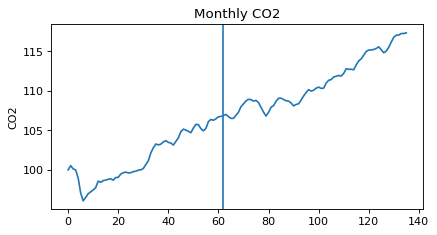

0    100.00000
1    100.52510
2    100.12380
3     99.98538
4     98.97539
Name: CPI, dtype: float64

In [ ]:
plt.figure(figsize=(6, 3), dpi=80)
subset = df.CPI
sns.lineplot(subset)
plt.title("Monthly CO2")
plt.ylabel('CO2')
split_position = df_test.index[0]
plt.axvline(split_position)
plt.show()
subset.head()

### Fitting Linear Model

aplpha0 =  [96.72932633]
alpha1 =  [[0.16104348]]


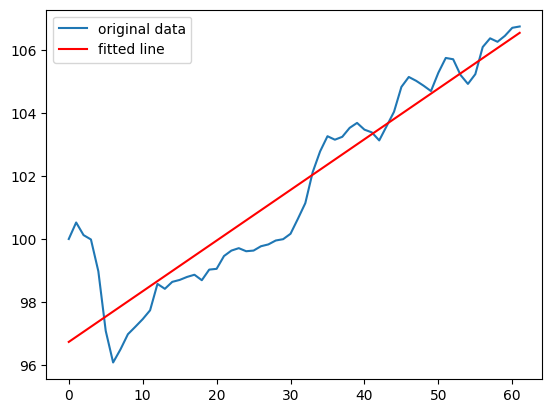

RMSE Linear model =  1.8007900862687192
MAPE Linear model =  1.435202517195968
3.634730187605456
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]


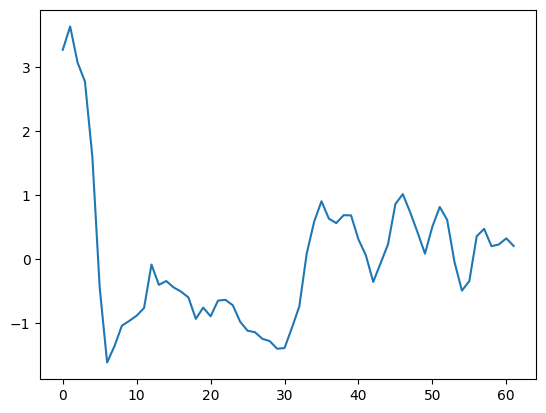

In [ ]:
x = df_train.index.values.reshape(-1, 1)
y = df_train.CPI.values.reshape(-1, 1)
x_test = df_test.index.values.reshape(-1, 1)
y_test = df_test.CPI.values.reshape(-1, 1)

clf = linear_model.LinearRegression()
clf.fit(x, y)
print('aplpha0 = ', clf.intercept_)
print('alpha1 = ', clf.coef_)
y_hat = clf.predict(x)
plt.plot(x, y, label='original data')
plt.plot(x, y_hat, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = y - y_hat
plt.plot(x, linear_residuals)

y_hat_test = clf.predict(x_test)
print('RMSE Linear model = ',np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))
print('MAPE Linear model = ',metrics.mean_absolute_percentage_error(y_test, y_hat_test)*100)

print(np.max(np.abs(linear_residuals)))

print(x.flatten())

### ACF/PACF Plots

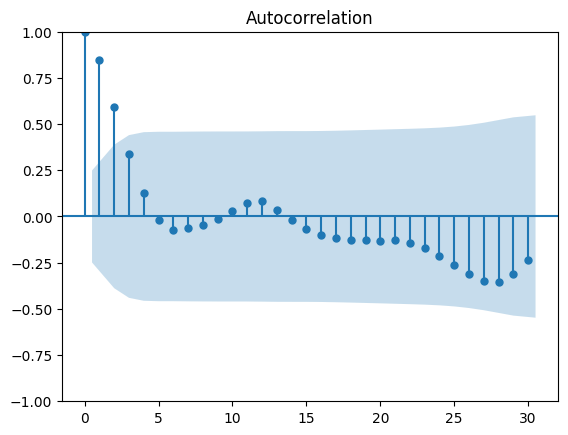

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


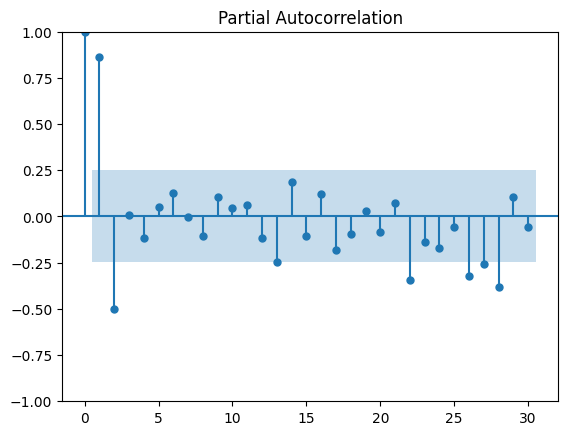

In [ ]:
sm.graphics.tsa.plot_acf(linear_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(linear_residuals, lags=30)
plt.show()

### AutoRegressive Parameters

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   62
Model:                     AutoReg(2)   Log Likelihood                 -17.470
Method:               Conditional MLE   S.D. of innovations              0.324
Date:                Tue, 18 Apr 2023   AIC                             42.939
Time:                        01:37:04   BIC                             51.317
Sample:                             2   HQIC                            46.216
                                   62                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0431      0.042     -1.024      0.306      -0.126       0.039
y.L1           1.3237      0.098     13.461      0.000       1.131       1.516
y.L2          -0.5308      0.091     -5.824      0.0

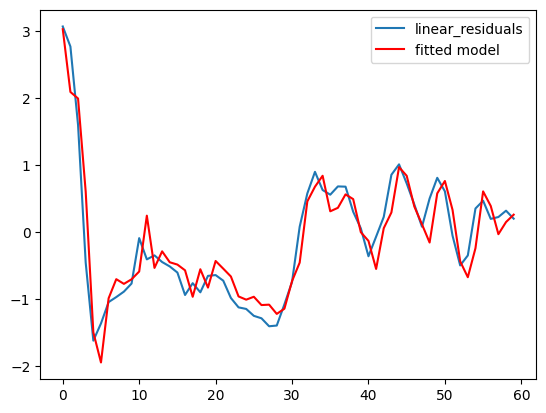

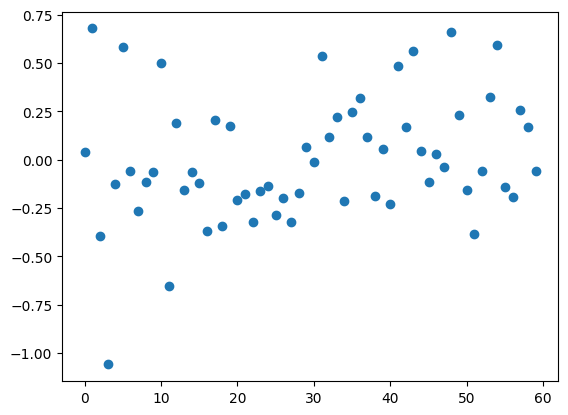

In [ ]:
# With a Python package
# model = AutoReg(y, lags=2, trend='t').fit()
lags = 2
model = AutoReg(linear_residuals, lags=lags).fit()
print(model.summary())
model_predictions = model.predict()
plt.plot(linear_residuals[lags:], label='linear_residuals')
plt.plot(model_predictions[lags:], 'r', label='fitted model')
plt.legend()
plt.plot()
plt.show()
residuals = linear_residuals[lags:] - model_predictions.reshape(-1,1)[lags:]
plt.plot(residuals,'o');

# print(len(linear_residuals))
# print('-----\n', len(model_predictions.reshape(-1,1)))

# print('-----\n', linear_residuals)
# print('-----\n', model_predictions.reshape(-1,1))

### RMSE

In [ ]:
# trend
Beta = clf.intercept_
Alpha = clf.coef_[0]

# AR order p=2
C = model.params[0]
Phi1 = model.params[1]
Phi2 = model.params[2]


# detrend column
df_test_comp['detrend']=df_test_comp.CPI.values-(Beta+Alpha*df_test_comp.index.values)

print(df_test_comp)
errors = []
for i in df_test_comp.index.values[2:]:
  # AR prediction
  pred = C+(df_test_comp.detrend[i-1])*Phi1+(df_test_comp.detrend[i-2])*Phi2
  error = pred-df_test_comp.detrend[i]
  errors.append(error)


RMSE = np.sqrt(np.mean(np.array(errors)**2))
print('rmse:',RMSE)

          date       CPI   detrend
60  2013-07-01  106.7130  0.321065
61  2013-08-01  106.7551  0.202121
62  2013-09-01  106.8835  0.169478
63  2013-10-01  107.0078  0.132734
64  2013-11-01  106.7322 -0.303909
..         ...       ...       ...
131 2019-06-01  117.0359 -0.790123
132 2019-07-01  117.0592 -0.927866
133 2019-08-01  117.2548 -0.893310
134 2019-09-01  117.2488 -1.060353
135 2019-10-01  117.3407 -1.129497

[76 rows x 3 columns]
rmse: 0.3910404306996486


# (5) Converting to Inflation Rates

## (5.1) Written Report

### (5.1.1)
(1 point) Description of how you compute the monthly inflation rate from  and a plot of the monthly inflation rate. (You may choose to work with log of the CPI.)

Inflation Rate of CPI Analysis (Written report)

### Converting to Inflation rate

In [ ]:
df = cpi_df_monthly
df.CPI = np.log(df.CPI.values)
IR = (df.CPI.values[1:]-df.CPI.values[:-1])/df.CPI.values[:-1]
df['IR'] = None
# Insert your values from row 1
df.iloc[1:, df.columns.get_loc('IR')] = IR
print(df)

IR_df_monthly = df
# print(IR)
# print('df length:',len(df))
# print('IR lenghth:',len(IR))

          date       CPI        IR
0   2008-07-24  0.423423      None
1   2008-08-01  0.424167  0.001757
2   2008-09-01  0.423599 -0.001339
3   2008-10-01  0.423402 -0.000464
4   2008-11-01  0.421956 -0.003416
..         ...       ...       ...
131 2019-06-01  0.445178  0.000643
132 2019-07-01  0.445205   0.00006
133 2019-08-01  0.445430  0.000504
134 2019-09-01  0.445423 -0.000015
135 2019-10-01  0.445528  0.000236

[136 rows x 3 columns]


<ipython-input-251-d6f3f24d272f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.CPI = np.log(df.CPI.values)
<ipython-input-251-d6f3f24d272f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IR'] = None


### splitting dataset

In [ ]:
df = IR_df_monthly
df_train = df[df['date'] < '2013-09-01']
df_test = df[df['date'] >= '2013-09-01']

print(df_test)

df_test_comp = df_train.tail(2).append(df_test)
df_test_comp



          date       CPI        IR
62  2013-09-01  0.432776  0.000386
63  2013-10-01  0.432938  0.000373
64  2013-11-01  0.432580 -0.000827
65  2013-12-01  0.432295 -0.000657
66  2014-01-01  0.432284 -0.000027
..         ...       ...       ...
131 2019-06-01  0.445178  0.000643
132 2019-07-01  0.445205   0.00006
133 2019-08-01  0.445430  0.000504
134 2019-09-01  0.445423 -0.000015
135 2019-10-01  0.445528  0.000236

[74 rows x 3 columns]


<ipython-input-252-02c0b932fbb0>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_comp = df_train.tail(2).append(df_test)


,date,CPI,IR
60,2013-07-01,0.432555,0.000771
61,2013-08-01,0.432609,0.000127
62,2013-09-01,0.432776,0.000386
63,2013-10-01,0.432938,0.000373
64,2013-11-01,0.432580,-0.000827
...,...,...,...
131,2019-06-01,0.445178,0.000643
132,2019-07-01,0.445205,0.00006
133,2019-08-01,0.445430,0.000504
134,2019-09-01,0.445423,-0.000015


### Plot Inflation rate

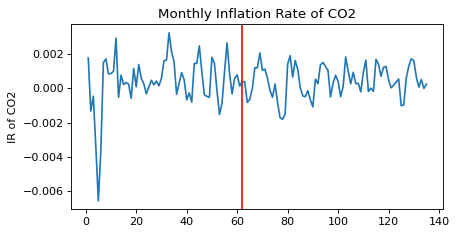

1    0.001757
2   -0.001339
3   -0.000464
4   -0.003416
5   -0.006564
Name: IR, dtype: object

In [ ]:
plt.figure(figsize=(6, 3), dpi=80)
subset = df.IR[1:]
sns.lineplot(subset)
plt.title("Monthly Inflation Rate of CO2")
split_position = df_test.index[0]
plt.axvline(split_position, color='red')
plt.ylabel('IR of CO2')
plt.show()
subset.head()

### (5.1.2)
(2 points) Description of how the data has been detrended and a plot of the detrended data.

### Fitting Linear Model

aplpha0 =  [-0.00021018]
alpha1 =  [[1.81703763e-05]]


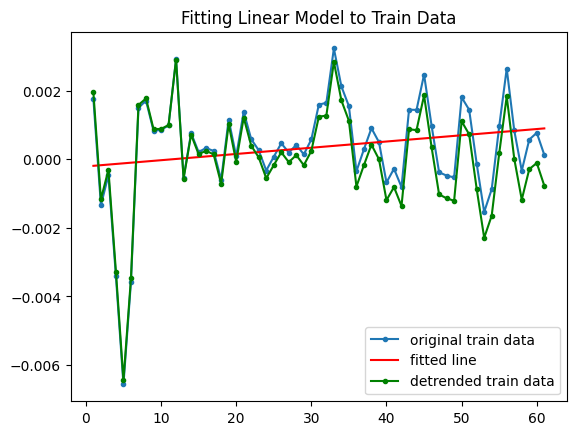

RMSE Linear model =  0.0014934053675625543
MAPE Linear model =  1109.1163326874514
0.006444387555781748
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61]


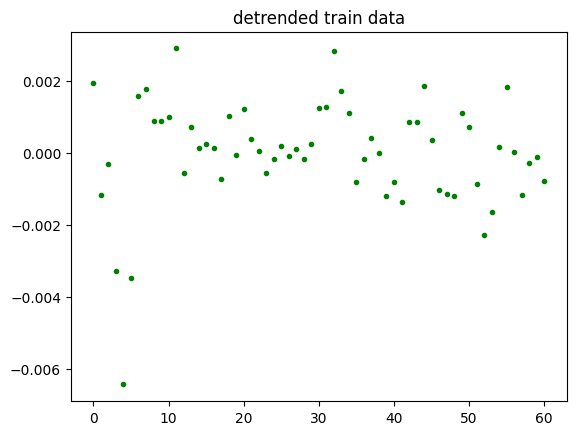

In [ ]:
x = df_train.iloc[1:,:].index.values.reshape(-1, 1)
y = df_train.iloc[1:,:].IR.values.reshape(-1, 1)
x_test = df_test.index.values.reshape(-1, 1)
y_test = df_test.IR.values.reshape(-1, 1)

# print(x)
# print(y)
# print(df)


clf = linear_model.LinearRegression()
clf.fit(x, y)
print('aplpha0 = ', clf.intercept_)
print('alpha1 = ', clf.coef_)
y_hat = clf.predict(x)
plt.plot(x, y, '.-' , label='original train data')
plt.plot(x, y_hat, 'r', label='fitted line')
plt.legend()
# plt.show()
linear_residuals = y - y_hat
plt.plot(x, linear_residuals, '.-', label='detrended train data', color='green')
plt.title('Fitting Linear Model to Train Data')
plt.legend()
y_hat_test = clf.predict(x_test)
plt.show()

plt.plot(linear_residuals, '.', label='detrended train data', color='green')
plt.title('detrended train data')
print('RMSE Linear model = ',np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))
print('MAPE Linear model = ',metrics.mean_absolute_percentage_error(y_test, y_hat_test)*100)
print(np.max(np.abs(linear_residuals)))
print(x.flatten())

### (5.1.3)
(3 points) Statement of and justification for the chosen AR(p) model. Include plots and reasoning.

### ACF/PACF plots 1

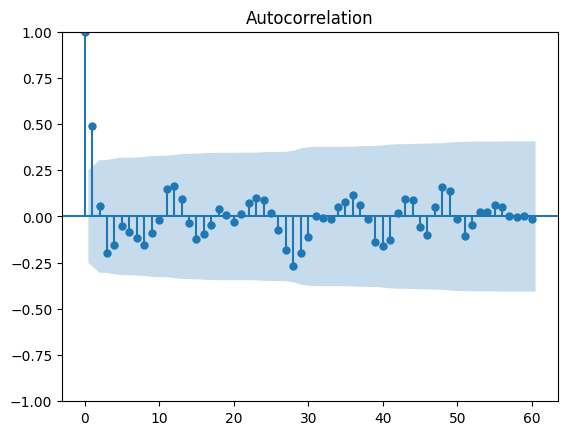

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


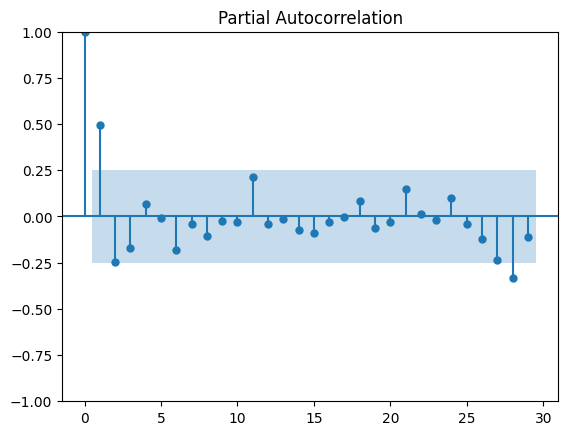

In [ ]:
sm.graphics.tsa.plot_acf(linear_residuals, lags=60)
plt.show()
sm.graphics.tsa.plot_pacf(linear_residuals, lags=29)
plt.show()

### AutoRegressive Parameters

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   61
Model:                     AutoReg(2)   Log Likelihood                 312.015
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Tue, 18 Apr 2023   AIC                           -616.030
Time:                        02:33:55   BIC                           -607.720
Sample:                             2   HQIC                          -612.786
                                   61                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.605e-06      0.000      0.023      0.982      -0.000       0.000
y.L1           0.6517      0.123      5.307      0.000       0.411       0.892
y.L2          -0.2599      0.121     -2.147      0.0

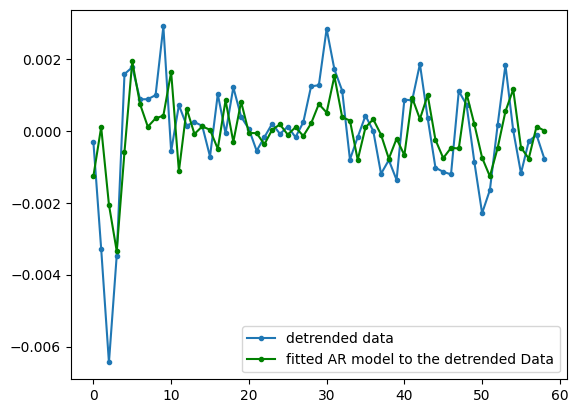

Text(0.5, 1.0, 'Residuals from subtracting fitted AR model from Detrended data ')

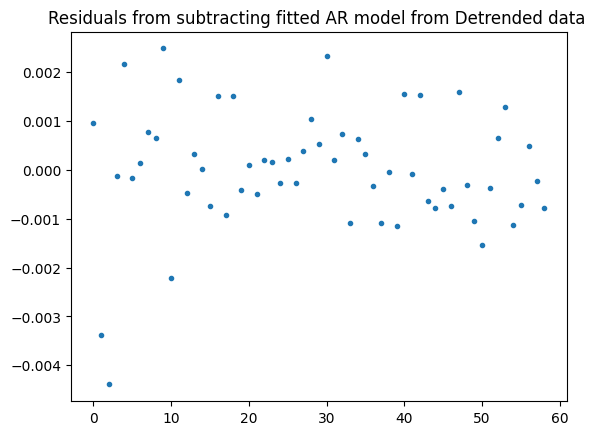

In [ ]:
# model = AutoReg(y, lags=2, trend='t').fit()
lags = 2
model = AutoReg(linear_residuals, lags=lags).fit()
print(model.summary())

model_predictions = model.predict()
plt.plot(linear_residuals[lags:],'.-', label='detrended data')
plt.plot(model_predictions[lags:], '.-g', label='fitted AR model to the detrended Data')
plt.legend()
plt.plot()
plt.show()
residuals = linear_residuals[lags:] - model_predictions.reshape(-1,1)[lags:]
plt.plot(residuals,'.', label = 'detrended data - fitted AR model')
plt.title('Residuals from subtracting fitted AR model from Detrended data ')


# print(len(linear_residuals))
# print('-----\n', len(model_predictions.reshape(-1,1)))

# print('-----\n', linear_residuals)
# print('-----\n', model_predictions.reshape(-1,1))

In [ ]:
# print(len(linear_residuals))
# print(len(model_predictions))
# print(linear_residuals)
# print(model_predictions)

### *ACF/PACF* plots 2

rmse= 0.0011526706152754768


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


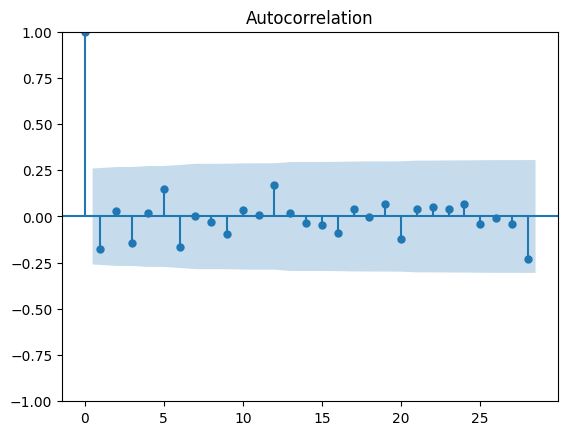

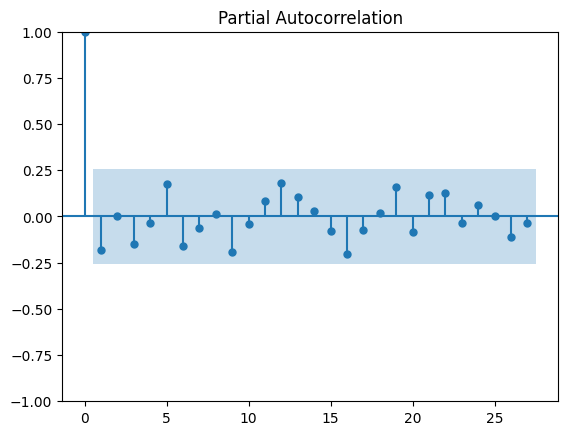

In [ ]:
print('rmse=',np.sqrt(np.mean(residuals[lags:]**2)))
# print(residuals)

# Create subplots
sm.graphics.tsa.plot_acf(residuals[lags:], lags=28)
sm.graphics.tsa.plot_pacf(residuals[lags:], lags=27)
plt.show()

### (5.1.4)
(3 points) Description of the final model; computation and plots of the 1 month-ahead forecasts for the validation data. In your plot, overlay predictions on top of the data.

### Validation

74
76
rmse: 0.0010335141840652632


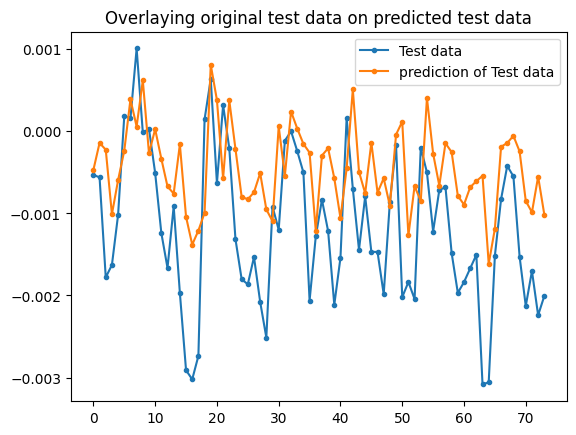

In [ ]:
# detrend the test data
x_test = df_test_comp.index.values.reshape(-1, 1)
y_test = df_test_comp.IR.values.reshape(-1, 1)

y_hat_test = clf.predict(x_test)

# print(y_hat_test)
# print(y_test)

linear_residuals_test_ir = y_test.flatten() - y_hat_test.flatten()
# print(len(y_hat_test))
# print(len(y_test))

# AR order p=2
C = model.params[0]
Phi1 = model.params[1]
Phi2 = model.params[2]

pred_test_ir = []

for i in range(2,len(linear_residuals_test_ir)):
  # print(i)
  # AR prediction
  pred = C + (Phi1*(linear_residuals_test_ir[i-1])) + (Phi2*(linear_residuals_test_ir[i-2]))
  # pred = C + (Phi1*(linear_residuals_test_ir[i-1]))

  pred_test_ir.append(pred)

print(len(pred_test_ir))
print(len(linear_residuals_test_ir))

res = pred_test_ir - linear_residuals_test_ir[lags:]
RMSE = np.sqrt(np.mean(np.array(res)**2))
print('rmse:',RMSE)


plt.plot(linear_residuals_test_ir[lags:], '.-', label='Test data')
plt.plot(pred_test_ir, '.-', label='prediction of Test data')
plt.title('Overlaying original test data on predicted test data')
plt.legend()
plt.show()

### (5.1.5)
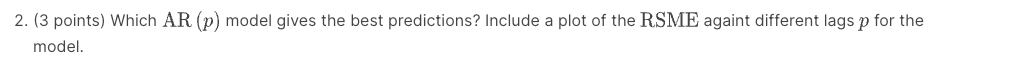

### AR with different Lags

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

[[-616.82188155]
 [-631.71132092]
 [-634.14536427]
 [-633.31461251]
 [-630.56883311]
 [-627.78388591]
 [-626.78814236]
 [-624.66588903]
 [-624.25325425]
 [-622.6640803 ]]
[[-612.60013382]
 [-625.37869933]
 [-625.70186882]
 [-622.76024319]
 [-617.90358993]
 [-613.00776886]
 [-609.90115145]
 [-605.66802425]
 [-603.14451561]
 [-599.44446779]]


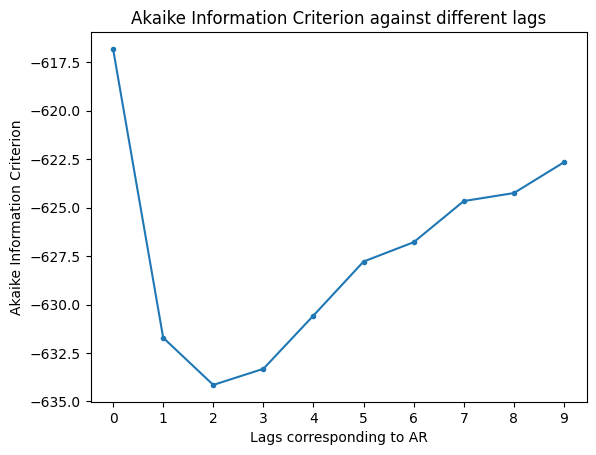

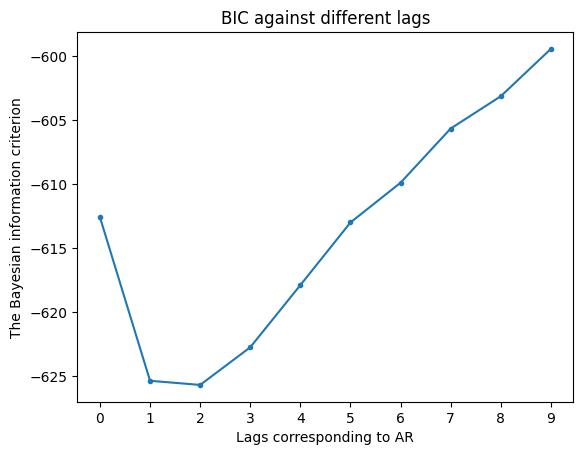

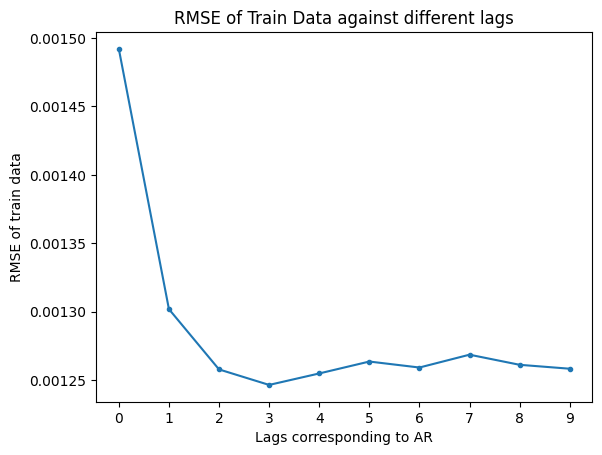

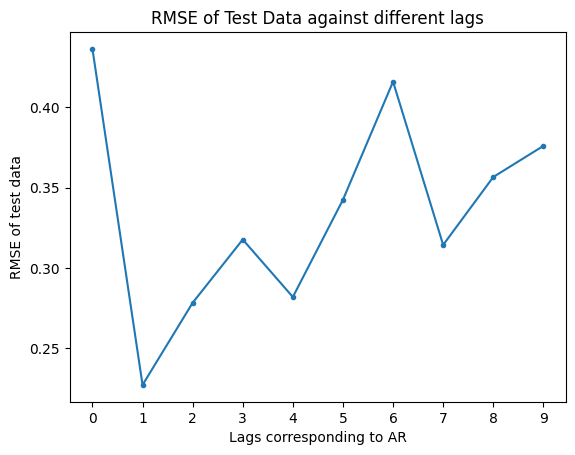

In [ ]:
def grid_search_ARIMA(x_train, x_test , AR_range):

  min_aic = np.inf
  min_bic = np.inf
  min_aic_index = None
  min_bic_index = None
  aic_matrix = np.zeros((len(AR_range), 1))
  bic_matrix = np.zeros((len(AR_range), 1))

  RMSES_train = []
  RMSES_test = []

  for AR_order in AR_range:
      arma = ARIMA(x_train, order=(AR_order, 0, 0)).fit()
      x_hat_train = arma.predict()
      arma_test = arma.apply(x_test)
      x_hat_test = arma_test.predict()

      res_train = x_hat_train - x_train

      aic_matrix[AR_order, 0] = arma.aic
      bic_matrix[AR_order, 0] = arma.bic

      if arma.aic < min_aic:
        min_aic = arma.aic
        min_aic_index = (AR_order, 0, 0)
      if arma.bic < min_bic:
        min_bic = arma.bic
        min_bic_index = (AR_order, 0, 0)


      res_test = x_hat_test - x_test
      rmse_train = np.sqrt(np.mean(res_train**2))

      rmse_test = np.sqrt(np.mean(res_test**2))
      RMSES_train.append(rmse_train)
      RMSES_test.append(rmse_test)

  return RMSES_train, RMSES_test, aic_matrix, bic_matrix


x = df_train.iloc[1:,:].index.values.reshape(-1, 1)
y = df_train.iloc[1:,:].IR.values.reshape(-1, 1)
x_test = df_test.index.values.reshape(-1, 1)
y_test = df_test.CPI.values.reshape(-1, 1)
clf = linear_model.LinearRegression()
clf.fit(x, y)
y_hat = clf.predict(x)
linear_residuals = y - y_hat
y_hat_test = clf.predict(x_test)
linear_residuals_test = y_test - y_hat_test

x1 = np.array(linear_residuals.flatten()).astype(float)
x2 = np.array(linear_residuals_test.flatten()).astype(float)
AR_range = range(0,10)
RMSES_train, RMSES_test, aic_matrix, bic_matrix = grid_search_ARIMA(x1, x2, AR_range)

print(aic_matrix)
print(bic_matrix)



# plot AIC
plt.plot(AR_range, aic_matrix.flatten(),'.-')
plt.xticks(AR_range,AR_range)
# Add labels and title
plt.xlabel('Lags corresponding to AR')
plt.ylabel('Akaike Information Criterion')
plt.title('Akaike Information Criterion against different lags')
plt.show()

# plot BIC
plt.plot(AR_range, bic_matrix.flatten(),'.-')
plt.xticks(AR_range,AR_range)
# Add labels and title
plt.xlabel('Lags corresponding to AR')
plt.ylabel('The Bayesian information criterion')
plt.title('BIC against different lags')
plt.show()


# plot Train RMSE
plt.plot(AR_range, RMSES_train,'.-')
plt.xticks(AR_range,AR_range)
# Add labels and title
plt.xlabel('Lags corresponding to AR')
plt.ylabel('RMSE of train data')
plt.title('RMSE of Train Data against different lags')
plt.show()

# plot Train RMSE
plt.plot(AR_range, RMSES_test,'.-')
plt.xticks(AR_range,AR_range)
# Add labels and title
plt.xlabel('Lags corresponding to AR')
plt.ylabel('RMSE of test data')
plt.title('RMSE of Test Data against different lags')
plt.show()


## (5.2) Written Report
(3 points) Overlay your estimates of monthly inflation rates and plot them on the same graph to compare. (There should be 3 lines, one for each datasets, plus the prediction, over time from September 2013 onward.)

### Inflation Rate from BER


Text(0.5, 1.0, 'Monthly BER')

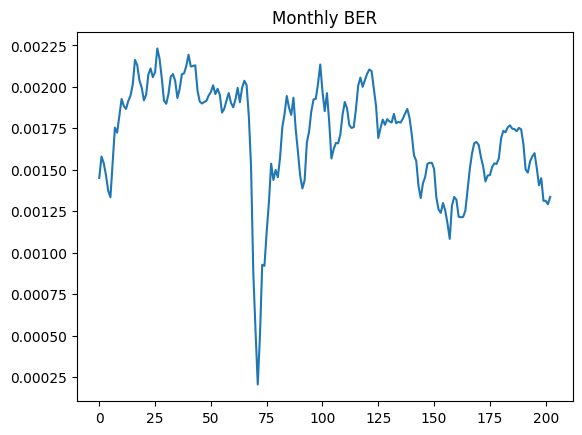

In [ ]:
ber_df = pd.read_csv('T10YIE.csv')

# Convert T10YIE to be not in percentage
ber_df.T10YIE = (ber_df.T10YIE.values)*0.01

# Convert 'DATE' column to datetime data type
ber_df['DATE'] = pd.to_datetime(ber_df['DATE'])

# Set 'DATE' column as the index
ber_df.set_index('DATE', inplace=True)

# Group data by month and calculate the average
ber_df_monthly = ber_df.resample('M').mean()

# Deannualize
ber_df_monthly.T10YIE = ((ber_df_monthly.T10YIE.values+1)**(1/12))-1

# Reset the index
ber_df_monthly.reset_index(inplace=True)

# ind2 = ((ber_df_monthly.DATE.dt.month==2).values) & ((ber_df_monthly.DATE.dt.year==2013).values)
# K2 = ber_df_monthly[ind2].T10YIE.values
# print(K2*100)

plt.plot(ber_df_monthly.T10YIE)
plt.title('Monthly BER')

In [ ]:
print(ber_df_monthly)


          DATE    T10YIE
0   2003-01-31  0.001450
1   2003-02-28  0.001580
2   2003-03-31  0.001539
3   2003-04-30  0.001467
4   2003-05-31  0.001374
..         ...       ...
198 2019-07-31  0.001449
199 2019-08-31  0.001312
200 2019-09-30  0.001313
201 2019-10-31  0.001292
202 2019-11-30  0.001336

[203 rows x 2 columns]


### splitting dataset

In [ ]:
df = ber_df_monthly

df_train = df[df['DATE'] < '2013-09-01']
df_test = df[df['DATE'] >= '2013-09-01']

df_test_comp = df_train.tail(2).append(df_test)
df_test_comp

print(df_train[50:70])
print(df_test)

df_test_comp = df_train.tail(2).append(df_test)
# df_test_comp

         DATE    T10YIE
50 2007-03-31  0.001968
51 2007-04-30  0.002009
52 2007-05-31  0.001956
53 2007-06-30  0.001988
54 2007-07-31  0.001952
55 2007-08-31  0.001845
56 2007-09-30  0.001868
57 2007-10-31  0.001918
58 2007-11-30  0.001962
59 2007-12-31  0.001904
60 2008-01-31  0.001877
61 2008-02-29  0.001923
62 2008-03-31  0.001994
63 2008-04-30  0.001907
64 2008-05-31  0.001995
65 2008-06-30  0.002036
66 2008-07-31  0.002010
67 2008-08-31  0.001823
68 2008-09-30  0.001517
69 2008-10-31  0.000881
          DATE    T10YIE
128 2013-09-30  0.001771
129 2013-10-31  0.001805
130 2013-11-30  0.001791
131 2013-12-31  0.001785
132 2014-01-31  0.001836
..         ...       ...
198 2019-07-31  0.001449
199 2019-08-31  0.001312
200 2019-09-30  0.001313
201 2019-10-31  0.001292
202 2019-11-30  0.001336

[75 rows x 2 columns]


<ipython-input-262-bd05b47c82f5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_comp = df_train.tail(2).append(df_test)
<ipython-input-262-bd05b47c82f5>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_comp = df_train.tail(2).append(df_test)


### Plot Inflation rate

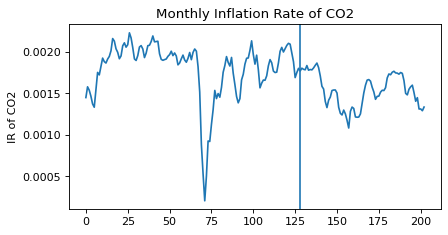

0    0.001450
1    0.001580
2    0.001539
3    0.001467
4    0.001374
Name: T10YIE, dtype: float64

In [ ]:
plt.figure(figsize=(6, 3), dpi=80)
subset = df.T10YIE
sns.lineplot(subset)
plt.title("Monthly Inflation Rate of CO2")
split_position = df_test.index[0]
plt.axvline(split_position)
plt.ylabel('IR of CO2')
plt.show()
subset.head()

### Fitting Linear Model

aplpha0 =  [0.00187764]
alpha1 =  [[-1.11168369e-06]]


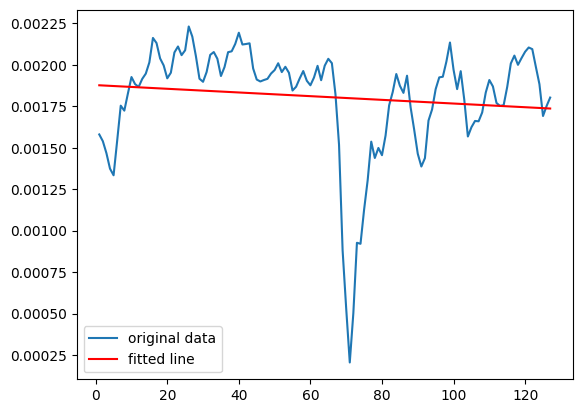

RMSE Linear model =  0.0002520546359104567
MAPE Linear model =  14.61702360264201
0.0015936421660022592
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127]


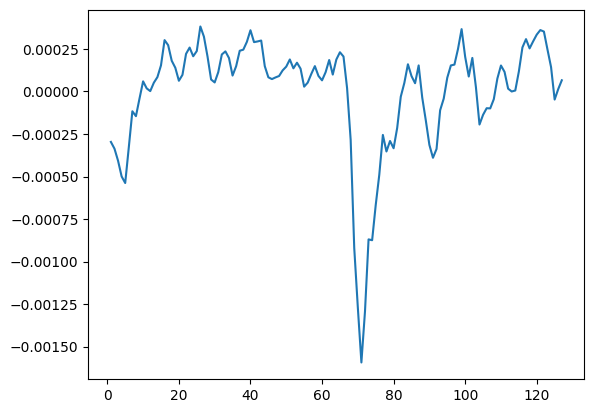

In [ ]:
x = df_train.iloc[1:,:].index.values.reshape(-1, 1)
y = df_train.iloc[1:,:].T10YIE.values.reshape(-1, 1)
x_test = df_test.index.values.reshape(-1, 1)
y_test = df_test.T10YIE.values.reshape(-1, 1)

# print(x)
# print(y)
# print(df)


clf = linear_model.LinearRegression()
clf.fit(x, y)
print('aplpha0 = ', clf.intercept_)
print('alpha1 = ', clf.coef_)
y_hat = clf.predict(x)
plt.plot(x, y, label='original data')
plt.plot(x, y_hat, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = y - y_hat
plt.plot(x, linear_residuals,label='residuals')

y_hat_test = clf.predict(x_test)

print('RMSE Linear model = ',np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))
print('MAPE Linear model = ',metrics.mean_absolute_percentage_error(y_test, y_hat_test)*100)
print(np.max(np.abs(linear_residuals)))
print(x.flatten())

### ACF/PACF plots 1

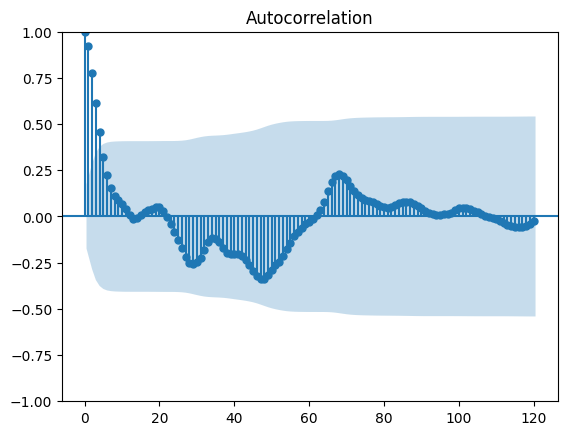

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


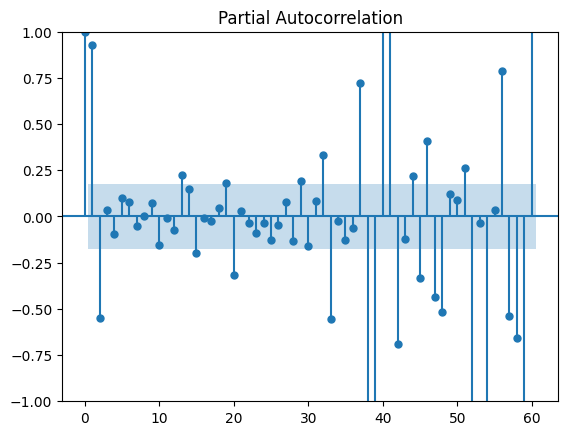

In [ ]:
sm.graphics.tsa.plot_acf(linear_residuals, lags=120)
plt.show()
sm.graphics.tsa.plot_pacf(linear_residuals, lags=60)
plt.show()

### AutoRegressive Parameters

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  127
Model:                     AutoReg(2)   Log Likelihood                 962.618
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Tue, 18 Apr 2023   AIC                          -1917.235
Time:                        02:34:40   BIC                          -1905.922
Sample:                             2   HQIC                         -1912.639
                                  127                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.178e-06   9.79e-06      0.222      0.824    -1.7e-05    2.14e-05
y.L1           1.3888      0.077     17.999      0.000       1.238       1.540
y.L2          -0.5033      0.077     -6.544      0.0

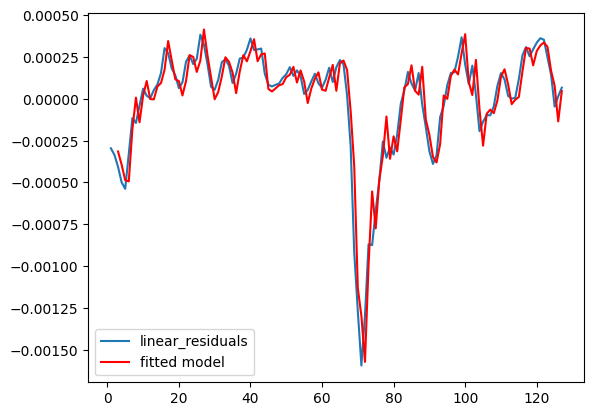

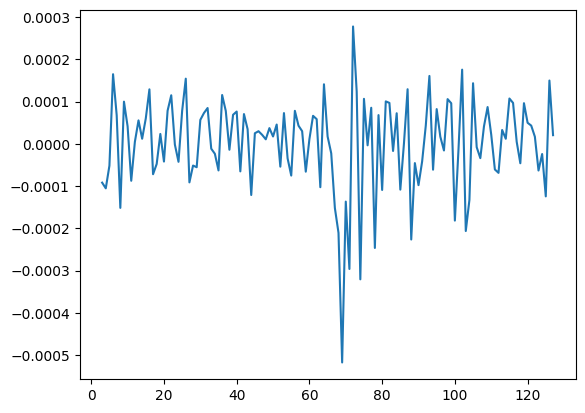

In [ ]:
# model = AutoReg(y, lags=2, trend='t').fit()
model = AutoReg(linear_residuals, lags=2).fit()
print(model.summary())

model_predictions = model.predict()
plt.plot(x, linear_residuals, label='linear_residuals')
plt.plot(x, model_predictions, 'r', label='fitted model')
plt.legend()
plt.plot()
plt.show()
residuals = linear_residuals - model_predictions.reshape(-1,1)
plt.plot(x, residuals);

### ACF/PACF Plots 2

rmse= 0.0001094679635351984


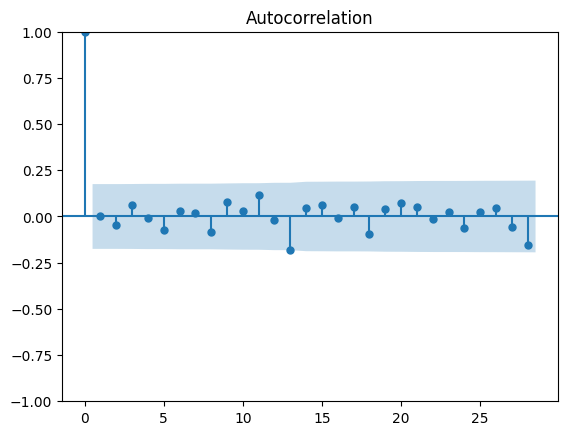

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


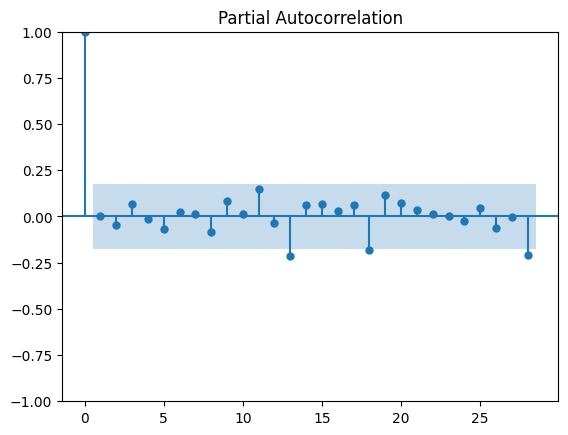

In [ ]:
print('rmse=',np.sqrt(np.mean(residuals[2:]**2)))
# print(residuals)
sm.graphics.tsa.plot_acf(residuals[2:], lags=28)
plt.show()
sm.graphics.tsa.plot_pacf(residuals[2:], lags=28)
plt.show()

rmse: 0.0002696991643069663


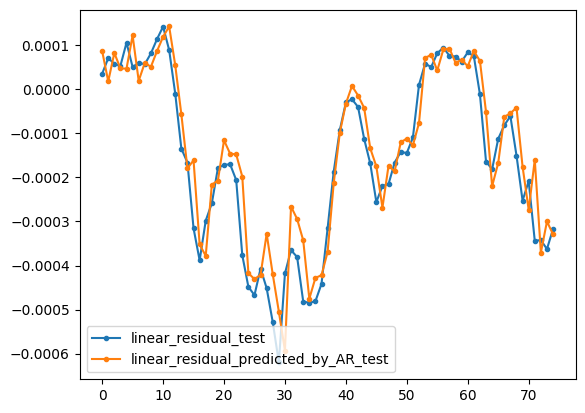

In [ ]:
x = df_train.iloc[1:,:].index.values.reshape(-1, 1)
y = df_train.iloc[1:,:].T10YIE.values.reshape(-1, 1)
x_test = df_test_comp.index.values.reshape(-1, 1)
y_test = df_test_comp.T10YIE.values.reshape(-1, 1)

# Train Linear Model
clf = linear_model.LinearRegression()
clf.fit(x, y)
# Predict test data with Linear model
y_hat_test = clf.predict(x_test)
# detrended test data
linear_residuals_test_ber = y_test - y_hat_test

# Train AR order p=2
C = model.params[0]
Phi1 = model.params[1]
Phi2 = model.params[2]

# Predict test data with AR(2)
pred_train = []

# print(x_test.flatten())
# print(y_hat_test.flatten())
# print(len(y_test))
# print(len(y_hat_test))
# print(pred_test)

n = len(linear_residuals_test_ber)
pred_test_ber = []
for i in range(2,n):
  # print(i)
  # AR prediction
  pred = C + (Phi1*(linear_residuals_test_ber.flatten()[i-1])) + (Phi2*(linear_residuals_test_ber.flatten()[i-2]))
  pred_test_ber.append(pred)

# print('len(y_test)',len(y_test))
# print('len(y_hat_test)',len(y_hat_test))
# print('len(pred_test_ber)',len(pred_test_ber))

res = pred_test_ber - linear_residuals_test_ber[lags:]
RMSE = np.sqrt(np.mean(np.array(res)**2))
print('rmse:',RMSE)

plt.plot(linear_residuals_test_ber.flatten()[2:], '.-', label = 'linear_residual_test')
# plt.plot(y_hat_test.flatten()[2:], '.-', label = 'Y_hat_test_trend')
plt.plot(pred_test_ber, '.-', label = 'linear_residual_predicted_by_AR_test')

plt.legend()

### Overlay your estimates of monthly inflation rates and plot them on the same graph to compare

76
76
74
75


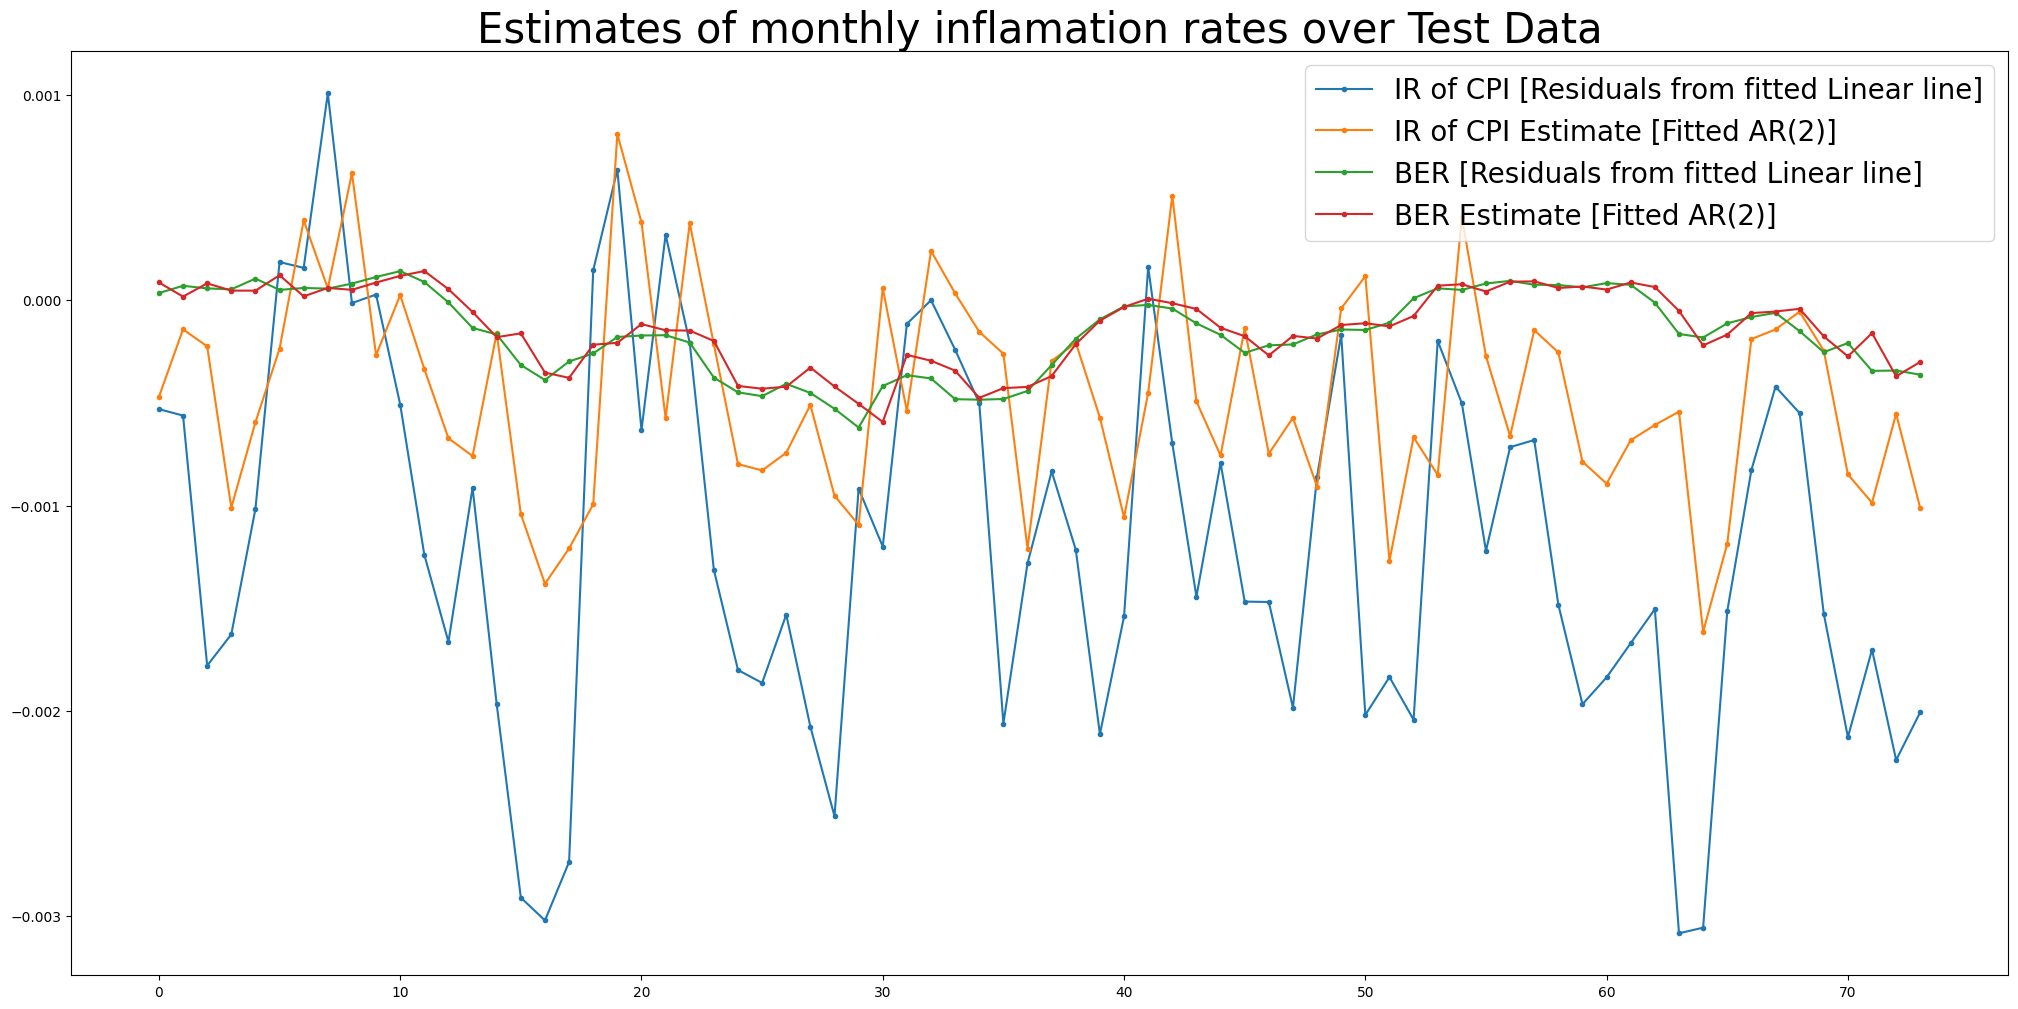

In [ ]:
print(len(linear_residuals_test_ir))
print(len(linear_residuals_test_ber.flatten()[:-1]))
print(len(pred_test_ir))
print(len(pred_test_ber))

A = linear_residuals_test_ir[lags:]
B = linear_residuals_test_ber.flatten()[lags:-1]
C = pred_test_ir
D = pred_test_ber[:-1]
plt.figure(figsize=(25,12))
plt.plot(A, '.-', label = 'IR of CPI [Residuals from fitted Linear line]')
plt.plot(C, '.-', label = 'IR of CPI Estimate [Fitted AR(2)]')
plt.plot(B, '.-', label = 'BER [Residuals from fitted Linear line]')
plt.plot(D, '.-', label = 'BER Estimate [Fitted AR(2)]')

plt.title('Estimates of monthly inflamation rates over Test Data',fontsize='30')
plt.legend(fontsize="20")


# (6) External Regressors and Model Improvements (Written Report)


## (6.1)
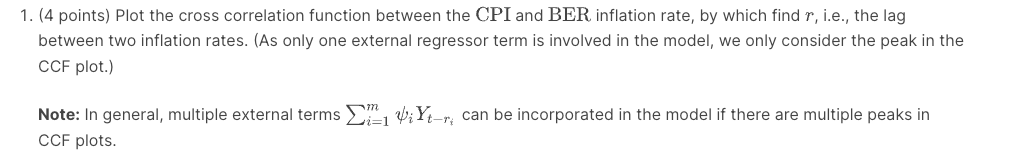

## Data preparation

In [ ]:
# IR
cpi_df = pd.read_csv('CPI.csv')
cpi_df.date = pd.to_datetime(cpi_df.date)
ind = cpi_df.date.dt.is_month_start
cpi_df['is-month-start'] = ind
cpi_df.iloc[0,2] = True
cpi_df_monthly = cpi_df[cpi_df['is-month-start']==True]
cpi_df_monthly.dropna(inplace=True)
cpi_df_monthly.drop('is-month-start',axis=1, inplace=True)
cpi_df_monthly.reset_index(drop=True, inplace=True)
cpi_df_monthly.CPI = np.log(cpi_df_monthly.CPI.values)
IR = (cpi_df_monthly.CPI.values[1:]-cpi_df_monthly.CPI.values[:-1])/cpi_df_monthly.CPI.values[:-1]
cpi_df_monthly['IR'] = None
# Insert your values from row 1
cpi_df_monthly.iloc[1:, cpi_df_monthly.columns.get_loc('IR')] = IR
IR_df_monthly = cpi_df_monthly

# BER
ber_df = pd.read_csv('T10YIE.csv')
# Convert T10YIE to be not in percentage
ber_df.T10YIE = (ber_df.T10YIE.values)*0.01
# Convert 'DATE' column to datetime data type
ber_df['DATE'] = pd.to_datetime(ber_df['DATE'])
# Set 'DATE' column as the index
ber_df.set_index('DATE', inplace=True)
# Group data by month and calculate the average
ber_df_monthly = ber_df.resample('M').mean()
# Deannualize
ber_df_monthly.T10YIE = ((ber_df_monthly.T10YIE.values+1)**(1/12))-1
# Reset the index
ber_df_monthly.reset_index(inplace=True)



df1 = ber_df_monthly
df2 = IR_df_monthly

# Set "DATE" column as index
df1['DATE'] = df1['DATE'].dt.to_period('M')
df1 = df1.set_index('DATE')

# rename Df2
df2 = df2.rename(columns={"date": "DATE"})
# Set "DATE" column as index
df2['DATE'] = df2['DATE'].dt.to_period('M')
df2 = df2.set_index('DATE')

<ipython-input-5-2275f90c48b6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_df_monthly.dropna(inplace=True)
<ipython-input-5-2275f90c48b6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_df_monthly.drop('is-month-start',axis=1, inplace=True)
<ipython-input-5-2275f90c48b6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_df_monthly.CPI = np.log(cpi_df_monthly.CPI

In [ ]:
print(df1)
print(df2)


# Merge the dataframes on the common dates
merged_df = pd.merge(df1, df2, how='inner', right_index = True, left_index = True)

# Select only the "IR" and "T10YIE" columns
result_df = merged_df[['IR', 'T10YIE']]
result_df = result_df.dropna()
print(result_df)


           T10YIE
DATE             
2003-01  0.001450
2003-02  0.001580
2003-03  0.001539
2003-04  0.001467
2003-05  0.001374
...           ...
2019-07  0.001449
2019-08  0.001312
2019-09  0.001313
2019-10  0.001292
2019-11  0.001336

[203 rows x 1 columns]
              CPI        IR
DATE                       
2008-07  4.605170      None
2008-08  4.610407  0.001137
2008-09  4.606407 -0.000868
2008-10  4.605024   -0.0003
2008-11  4.594871 -0.002205
...           ...       ...
2019-06  4.762481  0.000447
2019-07  4.762680  0.000042
2019-08  4.764349  0.000351
2019-09  4.764298 -0.000011
2019-10  4.765082  0.000164

[136 rows x 2 columns]
               IR    T10YIE
DATE                       
2008-08  0.001137  0.001823
2008-09 -0.000868  0.001517
2008-10   -0.0003  0.000881
2008-11 -0.002205  0.000530
2008-12 -0.004209  0.000205
...           ...       ...
2019-06  0.000447  0.001406
2019-07  0.000042  0.001449
2019-08  0.000351  0.001312
2019-09 -0.000011  0.001313
2019-10  0.000164 

## Splitting DataSet

In [ ]:
df = result_df

df_train = df[df.index < '2013-09-01']
df_test = df[df.index >= '2013-09-01']

df_test_comp = df_train.tail(2).append(df_test)
df_test_comp



<ipython-input-7-0fd9e8409384>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_comp = df_train.tail(2).append(df_test)


,IR,T10YIE
DATE,,
2013-07,0.000514,0.001752
2013-08,0.000084,0.001802
2013-09,0.000257,0.001771
2013-10,0.000249,0.001805
2013-11,-0.000552,0.001791
...,...,...
2019-06,0.000447,0.001406
2019-07,0.000042,0.001449
2019-08,0.000351,0.001312


## Correlation
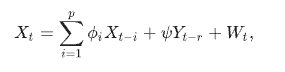

SignificanceResult(statistic=0.2982588347541823, pvalue=0.019559263735284257)

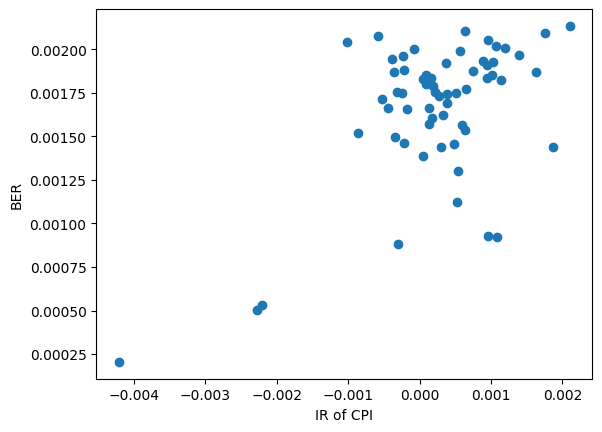

In [ ]:
Y = df_train['T10YIE']
X = df_train['IR']

from scipy import stats
plt.scatter(X, Y)
plt.xlabel('IR of CPI')
plt.ylabel('BER')
plt.title('')
stats.spearmanr(X ,Y)

## Cross-Corealation function


<ipython-input-9-fef290fc0f1e>:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, cross_corr, use_line_collection=True)


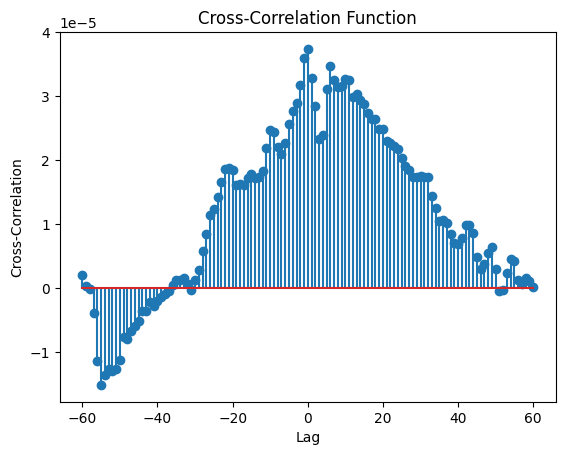

In [ ]:
x = X
y = Y
# Calculate cross-correlation function
cross_corr = np.correlate(x, y, mode='full')

# Create x-axis values for the cross-correlation function
lags = np.arange(-len(x) + 1, len(x))

# Plot the cross-correlation function
plt.stem(lags, cross_corr, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation Function')
plt.show()

In [ ]:
# print(cross_corr)
print(len(cross_corr)/2)
df3 = pd.DataFrame({'correlation':cross_corr})
df3.index = lags
df3 = df3.dropna()
df3 = pd.to_numeric(df3['correlation'])
df3.sort_values(ascending=False)


60.5


 0     0.000037
-1     0.000036
 6     0.000035
 1     0.000033
 10    0.000033
         ...   
-51   -0.000013
-53   -0.000013
-52   -0.000013
-54   -0.000014
-55   -0.000015
Name: correlation, Length: 121, dtype: float64

## (6.2)
(3 points) Fit a new  model to the  inflation rate with these external regressors and the most appropriate lag. Report the coefficients, and plot the 1 month-ahead forecasts for the validation data. In your plot, overlay predictions on top of the data.

## AutoRegressive

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 348.434
Date:                Tue, 18 Apr 2023   AIC                           -688.869
Time:                        17:15:49   BIC                           -680.425
Sample:                             0   HQIC                          -685.559
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2099      0.120      1.743      0.081      -0.026       0.446
ar.L1          0.6363      0.112      5.689      0.000       0.417       0.856
ar.L2         -0.2421      0.113     -2.150      0.0

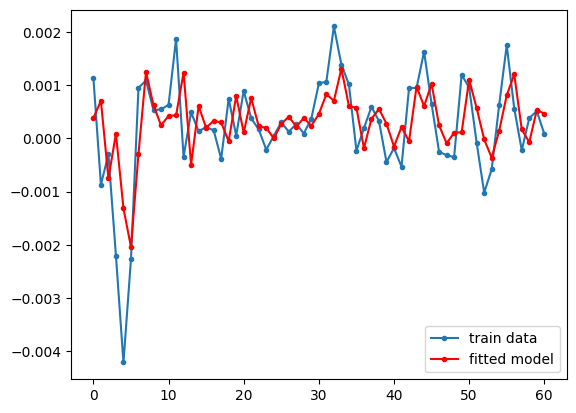

RMSE for Train Data= 0.0008
Exogenous Parameter 1 =  0.21
AutoRegressive Lag 1 =  0.64
AutoRegressive Lag 2 =  -0.24


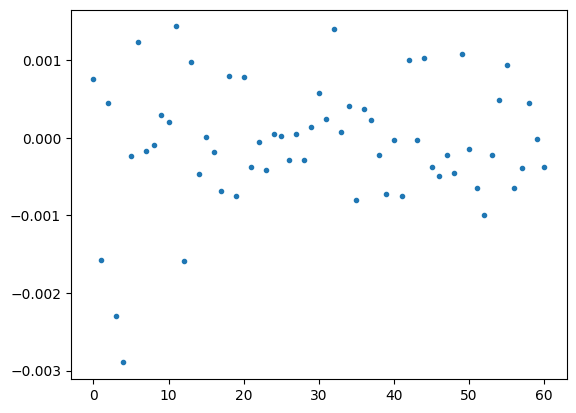

In [ ]:
exog = df_train['T10YIE'].values
endog = df_train['IR'].values.astype(float)
lags = 2

model = SARIMAX(endog=endog, exog=exog, order=(lags, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None).fit()
print(model.summary())

model_predictions = model.predict()
plt.plot(endog,'.-', label='train data')
plt.plot(model_predictions, '.-r', label='fitted model')
plt.legend()
plt.plot()
plt.show()
residuals = endog - model_predictions.reshape(-1,1).flatten()
plt.plot(residuals,'.');

print('RMSE for Train Data=',round(np.sqrt(np.mean(residuals**2)),5))
# print(endog)
# print(model_predictions.reshape(-1,1).flatten())

# Access the coefficients
coefficients = model.params
print('Exogenous Parameter 1 = ',round(coefficients[0],2))
print('AutoRegressive Lag 1 = ',round(coefficients[1],2))
print('AutoRegressive Lag 2 = ',round(coefficients[2],2))


## ACF/PACF

rmse= 0.000781555436731309


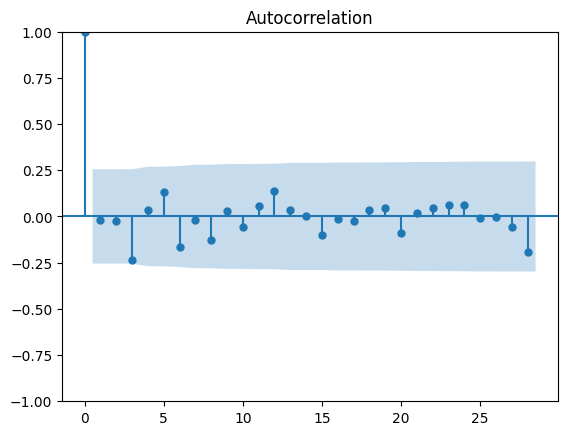

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


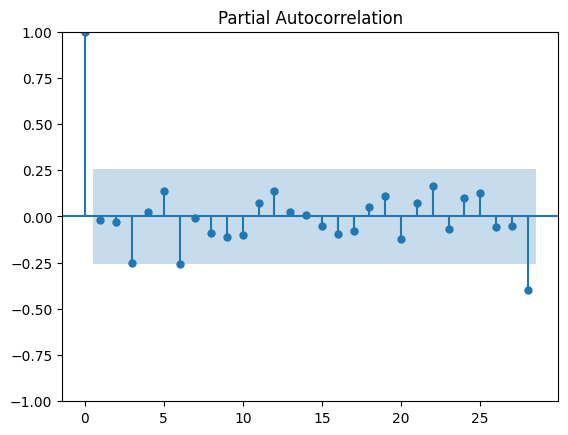

In [ ]:
print('rmse=',np.sqrt(np.mean(residuals[lags:]**2)))
# print(residuals)
sm.graphics.tsa.plot_acf(residuals[lags:], lags=28)
plt.show()
sm.graphics.tsa.plot_pacf(residuals[lags:], lags=28)
plt.show()

## plot the 1 month-ahead forecasts for the validation data

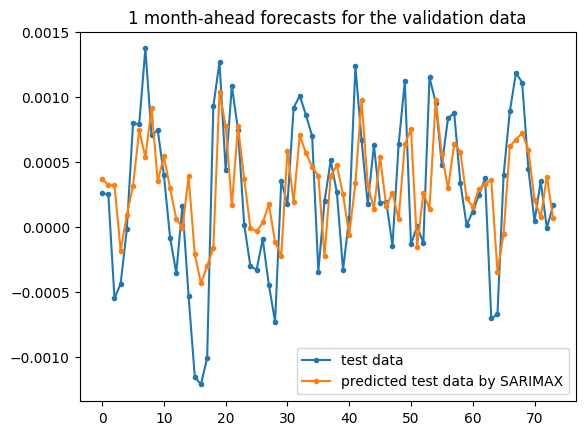

In [ ]:
endog_test = df_test['IR'].values.astype(float)
exog_test = df_test['T10YIE'].values

# using trained model
arma_test = model.apply(endog=endog_test, exog=exog_test)
endog_hat_test = arma_test.predict()

plt.plot(endog_test, '.-', label = 'test data')
plt.plot(endog_hat_test.flatten(), '.-', label = 'predicted test data by SARIMAX')
plt.title('1 month-ahead forecasts for the validation data')
plt.legend()

## (6.3)
Report the mean squared prediction error for 1 month ahead forecasts.

In [ ]:
print('RMSE for 1 month ahead forecast of test data = ',np.sqrt(np.mean((endog_test-endog_hat_test.flatten())**2)))

RMSE for 1 month ahead forecast of test data =  0.000487788545072631


## (6.4)

### Data Preperation

In [ ]:
# Computation Inflation rate with Log

# IR
cpi_df = pd.read_csv('CPI.csv')
cpi_df.date = pd.to_datetime(cpi_df.date)
# Set 'DATE' column as the index
cpi_df.set_index('date', inplace=True)
# Group data by month and calculate the average
cpi_df_monthly = cpi_df.resample('M').mean()
IR = (cpi_df_monthly.CPI.values[1:] - cpi_df_monthly.CPI.values[:-1])/cpi_df_monthly.CPI.values[:-1]
cpi_df_monthly['IR'] = None
# Insert your values from row 1
cpi_df_monthly.iloc[1:, cpi_df_monthly.columns.get_loc('IR')] = np.log(IR)
IR_df_monthly = cpi_df_monthly

# BER
ber_df = pd.read_csv('T10YIE.csv')
# Convert T10YIE to be not in percentage
ber_df.T10YIE = (ber_df.T10YIE.values)*0.01
# Convert 'DATE' column to datetime data type
ber_df['DATE'] = pd.to_datetime(ber_df['DATE'])
# Set 'DATE' column as the index
ber_df.set_index('DATE', inplace=True)
# Group data by month and calculate the average
ber_df_monthly = ber_df.resample('M').mean()
# Deannualize
ber_df_monthly.T10YIE = ((ber_df_monthly.T10YIE.values+1)**(1/12))-1
# Reset the index
ber_df_monthly.reset_index(inplace=True)



df1 = ber_df_monthly
df2 = IR_df_monthly

# Set "DATE" column as index
df1['DATE'] = df1['DATE'].dt.to_period('M')
df1 = df1.set_index('DATE')

# rename Df2
df2 = df2.rename(columns={"date": "DATE"})
# Set "DATE" column as index
df2['DATE'] = df2.index.to_period('M')
df2 = df2.set_index('DATE')


print(df1)
print(df2)


# Merge the dataframes on the common dates
merged_df = pd.merge(df1, df2, how='inner', right_index = True, left_index = True)

# Select only the "IR" and "T10YIE" columns
result_df = merged_df[['IR', 'T10YIE']]
result_df = result_df.dropna()
print(result_df)



df = result_df

df_train = df[df.index < '2013-09-01']
df_test = df[df.index >= '2013-09-01']

df_test_comp = df_train.tail(2).append(df_test)
df_test_comp

<ipython-input-23-f7ca10dbf42a>:13: RuntimeWarning: invalid value encountered in log
  cpi_df_monthly.iloc[1:, cpi_df_monthly.columns.get_loc('IR')] = np.log(IR)
<ipython-input-23-f7ca10dbf42a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_comp = df_train.tail(2).append(df_test)


           T10YIE
DATE             
2003-01  0.001450
2003-02  0.001580
2003-03  0.001539
2003-04  0.001467
2003-05  0.001374
...           ...
2019-07  0.001449
2019-08  0.001312
2019-09  0.001313
2019-10  0.001292
2019-11  0.001336

[203 rows x 1 columns]
               CPI        IR
DATE                        
2008-07  100.00000      None
2008-08  100.52510 -5.249337
2008-09  100.12380       NaN
2008-10   99.98538       NaN
2008-11   98.97539       NaN
...            ...       ...
2019-07  117.05920 -8.521783
2019-08  117.25480 -6.394363
2019-09  117.24880       NaN
2019-10  117.34070 -7.151352
2019-11        NaN       NaN

[137 rows x 2 columns]
               IR    T10YIE
DATE                       
2008-08 -5.249337  0.001823
2009-02 -5.437027  0.000927
2009-03 -5.303782  0.000921
2009-04 -6.019126  0.001126
2009-05 -5.992921  0.001304
...           ...       ...
2019-05 -5.240881  0.001509
2019-06 -6.152264  0.001406
2019-07 -8.521783  0.001449
2019-08 -6.394363  0.001312
2019-

,IR,T10YIE
DATE,,
2013-07,-6.032279,0.001752
2013-08,-7.837851,0.001802
2013-09,-6.723142,0.001771
2013-10,-6.756797,0.001805
2014-02,-5.594029,0.001780
2014-03,-5.600016,0.001789
2014-04,-5.045212,0.001784
2014-05,-5.714841,0.001808
2014-06,-5.657111,0.001839


RMSE Train Data =  1.380114862022797
RMSE Test = 1.8813507830489407


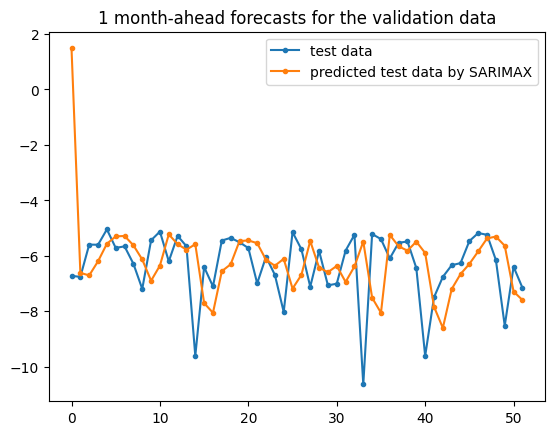

In [ ]:
def differencing(x):
  d = x[1:]-x[:-1]
  return d

def sarimax_(endog, exog, lags, lags_ma, trend, P, s):

  model = SARIMAX(endog=endog, exog=exog, order=(lags, 0, lags_ma), seasonal_order=(P, 0, 0, s), trend=trend).fit()
  model_predictions = model.predict()
  residuals = endog - model_predictions.reshape(-1,1).flatten()
  print('RMSE Train Data = ',np.sqrt(np.mean(residuals**2)))

  return model, residuals



# data
endog = df_train['IR'].values.astype(float)
exog = df_train['T10YIE'].values
endog_test = df_test['IR'].values.astype(float)
exog_test = df_test['T10YIE'].values

endog_diff = differencing(endog)
exog_diff = differencing(endog)
endog_test_diff = differencing(endog_test)
exog_test_diff = differencing(exog_test)

e1 = endog
e2 = exog
e1_test = endog_test
e2_test = exog_test

# print(df_train)
# print(endog)
# print(exog)
# print(endog_diff)
# print(exog_diff)

# 1) Training model
lags = 2
lags_ma = 0
trend = None #'ct'
P = 0
s = 0

model, residuals = sarimax_(e1, e2, lags, lags_ma, trend, P, s)

# 2) Testing Model
arma_test = model.apply(e1_test, e2_test)
e1_hat_test = arma_test.predict()

plt.plot(e1_test, '.-', label = 'test data')
plt.plot(e1_hat_test.flatten(), '.-', label = 'predicted test data by SARIMAX')
plt.title('1 month-ahead forecasts for the validation data')
plt.legend()
residuals = e1_test - e1_hat_test.reshape(-1,1).flatten()
# plt.plot(residuals,'.');
print('RMSE Test =',np.sqrt(np.mean(residuals**2)))

In [ ]:
def differencing(x):
  d = x[1:]-x[:-1]
  return d

def sarimax_(endog, exog, lags, lags_ma, trend, P, s):

  model = SARIMAX(endog=endog, exog=exog, order=(lags, 0, lags_ma), seasonal_order=(P, 0, 0, s), trend=trend).fit()
  model_predictions = model.predict()
  residuals = endog - model_predictions.reshape(-1,1).flatten()
  rmse = np.sqrt(np.mean(residuals**2))

  return model, rmse

def grid_search_SARIMAX(e1, e2, e1_test, e2_test):

  df = pd.DataFrame(columns=['AR lag', 'MA lag','trend','seasonal order','P','RMSE train','RMSE test'])
  i=0
  for lag_ar in range(0,15):

    for lag_ma in range(0,15):

      for s in [0]:

        for p in [0]:

          for t in ['t']:

            # 1) Training model
            p = 0
            model, rmse_train = sarimax_(e1, e2, lag_ar, lag_ma, t, p, s)

            # 2) Testing Model
            arma_test = model.apply(e1_test, e2_test)
            e1_hat_test = arma_test.predict()
            residuals_test = e1_test - e1_hat_test.reshape(-1,1).flatten()
            rmse_test = np.sqrt(np.mean(residuals**2))

            # 3) store results
            df.loc[i] = [int(lag_ar), int(lag_ma), t, int(s), int(p), rmse_train, rmse_test]
            i+=1


  return df


# data
endog = df_train['IR'].values.astype(float)
exog = df_train['T10YIE'].values
endog_test = df_test['IR'].values.astype(float)
exog_test = df_test['T10YIE'].values

endog_diff = differencing(endog)
exog_diff = differencing(endog)
endog_test_diff = differencing(endog_test)
exog_test_diff = differencing(exog_test)

e1 = endog
e2 = exog
e1_test = endog_test
e2_test = exog_test

# print(df_train)
# print(endog)
# print(exog)
# print(endog_diff)
# print(exog_diff)

df = grid_search_SARIMAX(e1, e2, e1_test, e2_test)
df

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/s

,AR lag,MA lag,trend,seasonal order,P,RMSE train,RMSE test
0,0,0,t,0,0,0.000948,0.000488
1,0,0,ct,0,0,0.000928,0.000488
2,0,0,n,0,0,0.000949,0.000488
3,0,0,c,0,0,0.000941,0.000488
4,0,0,t,2,0,0.000948,0.000488
...,...,...,...,...,...,...,...
1795,14,14,c,0,0,0.000941,0.000488
1796,14,14,t,2,0,0.000957,0.000488
1797,14,14,ct,2,0,0.000965,0.000488
1798,14,14,n,2,0,0.000774,0.000488


In [ ]:
df.sort_values('RMSE train', ascending=True)

,AR lag,MA lag,trend,seasonal order,P,RMSE train,RMSE test
107,0,13,c,0,0,0.000726,0.000488
111,0,13,c,2,0,0.000726,0.000488
587,4,13,c,0,0,0.000736,0.000488
591,4,13,c,2,0,0.000736,0.000488
1499,12,7,c,0,0,0.000737,0.000488
...,...,...,...,...,...,...,...
1769,14,11,ct,0,0,0.002477,0.000488
585,4,13,ct,0,0,0.002599,0.000488
589,4,13,ct,2,0,0.002599,0.000488
705,5,13,ct,0,0,0.002868,0.000488
